# Financial Sentiment Analysis with BERT Transfer Learning
**By Niko Liu**

Install all required packages

Warning: This notebook may require a GPU with memory(VRAM) >= 16GB, preferably >= 32GB to run. Otherwise, resource exhausted error may arise.

In [1]:
#Install all required packages
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import datasets
import evaluate
from evaluate import evaluator
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DistilBertConfig, DistilBertTokenizerFast, TFDistilBertModel, BertTokenizerFast, TFBertModel
from datasets import load_dataset
import random
import seaborn as sns
from pynvml import *
import scipy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from tabulate import tabulate
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from tensorflow import keras
# import tensorflow_datasets as tfds
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

random.seed(5)
seed = 5
%matplotlib inline

2023-05-08 04:02:07.769725: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 04:02:07.834703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 04:02:11.169025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Check if GPU is running

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    print("GPU(s) details:")
    for gpu in tf.config.list_physical_devices('GPU'):
        print(gpu)
else:
    print("GPU is not available")

GPU is available
GPU(s) details:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Define function to track GPU utilization in later stage

In [4]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

Check the Tensorflow version

In [5]:
print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.12.0
Version 2, minor 12


# Part I - Modelling pipeline

# Import HuggingFace dataset

## Get the data

In [6]:
raw_data = load_dataset("financial_phrasebank", "sentences_allagree")

Found cached dataset financial_phrasebank (/home/jl8831/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

## Have a look at the data

In [7]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [8]:
raw_data["train"][0]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'label': 1}

## Define Performance Measure

For this problem, we will perform NLP task, specifically sentiment analysis on financial phrasebank dataset from hugging face. We will likely measure the model performance by measuring its accuracy score and optionally, precision, recall or F1 score since we will have three class(positive, neutral and negative) dataset. 

## Create Test Set

In [9]:
test_size = 0.2
raw_data_split = raw_data['train'].train_test_split(test_size=test_size)
train_temp_set = raw_data_split['train']
test_set = raw_data_split['test']
train_temp_set_split = train_temp_set.train_test_split(test_size=test_size)
train_set = train_temp_set_split['train']
val_set = train_temp_set_split['test']

In [10]:
print("Data in training set:",len(train_set))
print("Data in validation set:",len(val_set))
print("Data in test set:",len(test_set))

Data in training set: 1448
Data in validation set: 363
Data in test set: 453


# Exploratory Data Analysis

In [11]:
train_df = train_set.to_pandas()
train_df.info()
# No null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1448 non-null   object
 1   label     1448 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.8+ KB


In [12]:
max_length = train_df['sentence'].apply(len).max()
print('The max sentence length in training data is:', max_length)

The max sentence length in training data is: 302


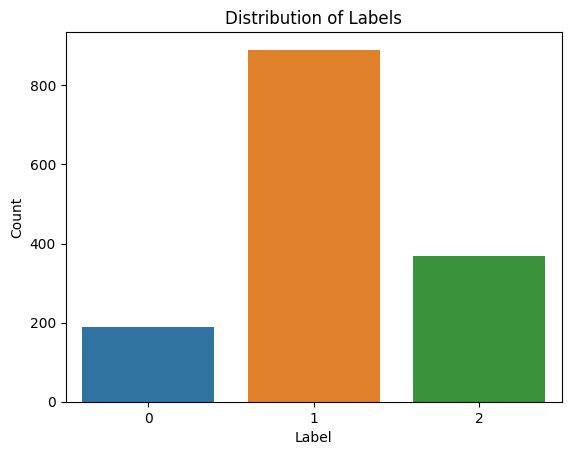

In [13]:
sns.countplot(data=train_df, x='label')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We observe some data imbalance issue in this data, in particular, class with label 1 is way more than others, we will handle it later

In [14]:
train_df['text_length'] = train_df['sentence'].apply(len)
mean_text_length = train_df['text_length'] .mean()
text_length_90pct = train_df['text_length'].quantile(0.90)

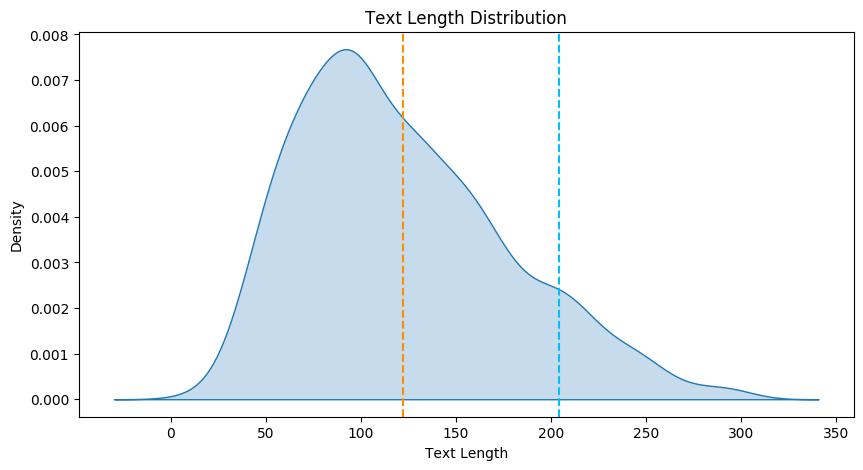

In [15]:
plt.figure(figsize=(10, 5))
sns.kdeplot(train_df['text_length'], fill=True)
plt.axvline(mean_text_length, color='darkorange', linestyle='--', label='Mean')
plt.axvline(text_length_90pct, color='deepskyblue', linestyle='--', label='90th Percentile')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.show()

We see that the average sentence length in dataset in around 125 and the 90 percentile of text length is around 200 words. \
Therefore, we will choose the max_length to 200 when truncating or tokenize the dataset

Text(0.5, 0.98, 'Text Length Distribution by Label')

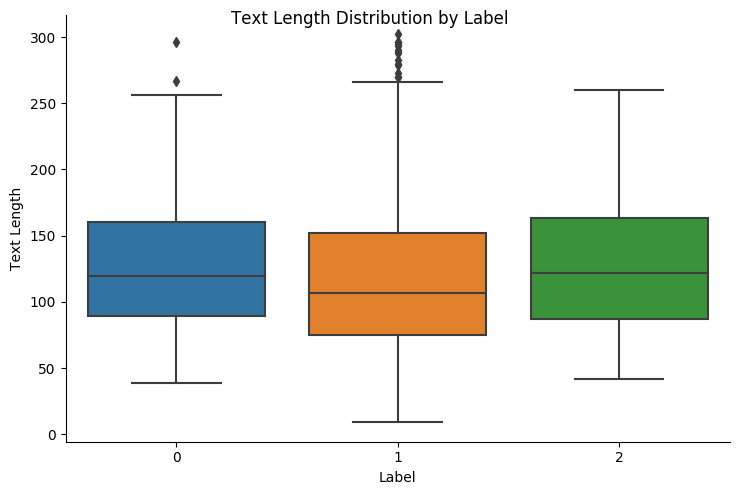

In [16]:
g = sns.catplot(x='label', y='text_length', data=train_df, kind='box', height=5, aspect=1.5)
g.set_axis_labels('Label', 'Text Length')
g.fig.suptitle('Text Length Distribution by Label')

We could also see that the distribution of text length is roughly similar to each other, so we would not have to worry about the imbalance of text length.

# Prepare the Data

Cleaning and Handle non-numeric attributes step can be skipped because the dataset is already processed and its text input

## Transformation

In [17]:
train_list = train_set['sentence']
train_label = train_set['label']
val_list = val_set['sentence']
val_label = val_set['label']
test_list = test_set['sentence']
test_label = test_set['label']
print_gpu_utilization()

GPU memory occupied: 526 MB.


## Tokenize

In [18]:
def tokenize_dataset(X, y, tokenizer_, max_len = 200):
    input_sequences = tokenizer_(X, padding="max_length",\
    max_length=max_len, truncation=True, return_tensors="tf")
    input_sequences = dict(input_sequences)
    input_ids = input_sequences['input_ids']
    attention_mask = input_sequences['attention_mask']
    input_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    labels = np.array(y)
    return input_dict, labels

In [19]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# train_input = tokenizer(train_list, padding="max_length", max_length=200, truncation=True, return_tensors="tf")
# val_input = tokenizer(val_list, padding="max_length", max_length=200, truncation=True, return_tensors="tf")
# test_input = tokenizer(test_list, padding="max_length", max_length=200, truncation=True, return_tensors="tf")
train_input, train_label = tokenize_dataset(train_list, train_label, tokenizer)
val_input, val_label = tokenize_dataset(val_list, val_label, tokenizer)
test_input, test_label = tokenize_dataset(test_list, test_label, tokenizer)

print_gpu_utilization()

GPU memory occupied: 45030 MB.


2023-05-08 04:02:25.545811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44129 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:86:00.0, compute capability: 7.5


In [20]:
train_input.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
train_input['input_ids'][0][:10]

<tf.Tensor: shape=(10,), dtype=int32, numpy=
array([  101, 15253,  2050,  1011, 28516,  6200,  2097,  5446,  1996,
        7909], dtype=int32)>

We verified that train_set is converted to a list and then converted to token identifiers. We also use padding techniques for better data uniformity and efficient batch processing

## Address any Imbalanced Data Issues (Extra Part)

In [22]:
train_ids, train_masks = list(train_input.values())
train_ids = np.array(train_ids)
train_masks = np.array(train_masks)
train_input_cat = np.concatenate([train_ids, train_masks], axis=1)

In [23]:
# under_sampler = RandomUnderSampler(sampling_strategy='auto',random_state=seed)
# train_list_resampled, train_label_resampled = under_sampler.fit_resample(train_input_cat, train_label)
# over_sampler = SMOTE(sampling_strategy='auto', k_neighbors=5,random_state=seed)
over_sampler = RandomOverSampler(sampling_strategy='not majority', random_state=seed)
train_list_resampled, train_label_resampled = over_sampler.fit_resample(train_input_cat, train_label)

Experiment with SMOTE techniques at first, but did not yield good result.\
Changed to random over sampler for all minority class.

In [24]:
train_ids_resampled = train_list_resampled[:, :train_ids.shape[1]]
train_masks_resampled = train_list_resampled[:, train_ids.shape[1]:]
train_input_resampled = {'input_ids':train_ids_resampled, 'attention_mask':train_masks_resampled}

Write an utility function for easy reuse later

In [25]:
def oversampling_bert(inputs_, labels_):
    ids, masks = list(inputs_.values())
    ids = np.array(ids)
    masks = np.array(masks)
    input_cat = np.concatenate([ids, masks], axis=1)
    sampler = RandomOverSampler(sampling_strategy='not majority', random_state=seed)
    list_resampled, label_resampled = sampler.fit_resample(input_cat, labels_)
    ids_resampled = list_resampled[:, :ids.shape[1]]
    masks_resampled = list_resampled[:, ids.shape[1]:]
    input_resampled = {'input_ids':ids_resampled, 'attention_mask':masks_resampled}
    return input_resampled, label_resampled

In [26]:
# train_input_resampled, train_label_resampled = oversampling_bert(train_input, train_label)

Visualize the class distribution after resampling

In [27]:
train_label_resampled_df = pd.DataFrame(train_label_resampled, columns = ['label'])

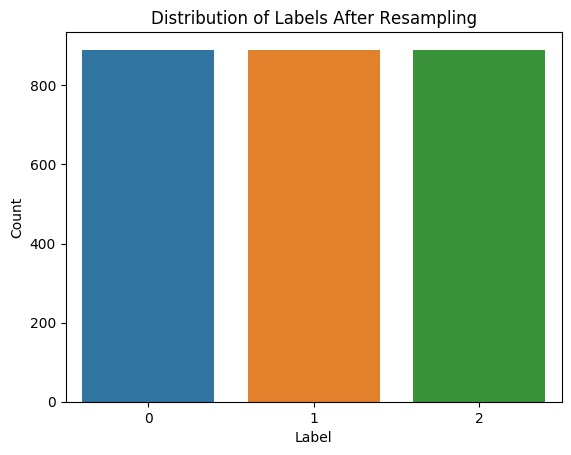

In [28]:
sns.countplot(data=train_label_resampled_df, x='label')
plt.title('Distribution of Labels After Resampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Utility Function for finding model weights
*from the class notebook*

In [29]:
def count_weights(weights_per_layer, prefix=None):
    # NOTE: the .weights attributed DOES NOT include biases (available via .bias attribute)
    count_weights = 0

    for layer, weights in enumerate(weights_per_layer):
        num_weights = np.prod(weights.shape)

        if prefix is not None:
            print(f"Trainable layer {layer} has {num_weights} weights")

        count_weights += num_weights

    return count_weights

def count_model_weights(model):
    all_weights = model.weights
    trainable_weights = model.trainable_weights

    num_layers = len( model.layers )

    # Control detailed output: supress if number of layers (length of trainable_weights) is too big
    out_prefix = "trainable" if len(trainable_weights) < 10 else None

    num_weights, num_trainable_weights = count_weights(all_weights, None), count_weights(trainable_weights, out_prefix)                                                                         

    return num_weights, num_trainable_weights

# Train a model

## Select the model

In [30]:
checkpoint = "distilbert-base-uncased"
bert_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
print_gpu_utilization()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

GPU memory occupied: 45222 MB.


## Train the head first

In [31]:
bert_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


We want to freeze the non-classifier layers

In [32]:
bert_model.layers[0].trainable = False

In [33]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [34]:
num_weights, num_trainable_weights = count_model_weights(bert_model)
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Trainable layer 0 has 589824 weights
Trainable layer 1 has 768 weights
Trainable layer 2 has 2304 weights
Trainable layer 3 has 3 weights
Total number of weights 66,955,779, number of trainable weights 592,899


We see that non-classifier layers are freeze and not trainable

## Fit & Validation

In [35]:
def train_bert_model(model, train_dataset, train_label, val_dataset, val_label, num_epochs=5, batch_size=16, verbose_=True):
    history = model.fit(train_dataset,
                        train_label,
                        batch_size=batch_size, epochs=num_epochs,
                        validation_data=(val_dataset,val_label),
                        verbose=verbose_,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                       )
    return history

In [36]:
bert_history_head = train_bert_model(bert_model, train_input_resampled, train_label_resampled,val_input,val_label)

Epoch 1/5


2023-05-08 04:02:37.846450: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x4208e6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 04:02:37.846518: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-05-08 04:02:37.856755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-08 04:02:38.103289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 04:02:38.159778: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 04:02:38.234078: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 [==============================] - 19s 77ms/step - loss: 0.8656 - accuracy: 0.6356 - val_loss: 0.5704 - val_accuracy: 0.8017
Epoch 2/5
167/167 [==============================] - 11s 69ms/step - loss: 0.6096 - accuracy: 0.7506 - val_loss: 0.4830 - val_accuracy: 0.8237
Epoch 3/5
167/167 [==============================] - 12s 69ms/step - loss: 0.5000 - accuracy: 0.7978 - val_loss: 0.4746 - val_accuracy: 0.8209
Epoch 4/5
167/167 [==============================] - 11s 68ms/step - loss: 0.4431 - accuracy: 0.8232 - val_loss: 0.3775 - val_accuracy: 0.8347
Epoch 5/5
167/167 [==============================] - 11s 69ms/step - loss: 0.4076 - accuracy: 0.8386 - val_loss: 0.3565 - val_accuracy: 0.8457


## Train all the layers

In [37]:
bert_model.layers[0].trainable = True

In [38]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [39]:
num_weights, num_trainable_weights = count_model_weights(bert_model)
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Total number of weights 66,955,779, number of trainable weights 66,955,779


In [40]:
bert_history = train_bert_model(bert_model, train_input_resampled, train_label_resampled,val_input,val_label)
# bert_history = train_bert_model(bert_model, train_input_resampled,train_label_resampled,val_input,val_label)

Epoch 1/5
167/167 [==============================] - 53s 221ms/step - loss: 0.1636 - accuracy: 0.9434 - val_loss: 0.1286 - val_accuracy: 0.9587
Epoch 2/5
167/167 [==============================] - 28s 166ms/step - loss: 0.0184 - accuracy: 0.9933 - val_loss: 0.0971 - val_accuracy: 0.9669
Epoch 3/5
167/167 [==============================] - 27s 163ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0953 - val_accuracy: 0.9697
Epoch 4/5
167/167 [==============================] - 26s 157ms/step - loss: 0.0208 - accuracy: 0.9966 - val_loss: 0.1294 - val_accuracy: 0.9697
Epoch 5/5
167/167 [==============================] - 25s 152ms/step - loss: 0.0402 - accuracy: 0.9884 - val_loss: 0.2805 - val_accuracy: 0.9449


## Error Analysis

In [41]:
def plot_bert_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

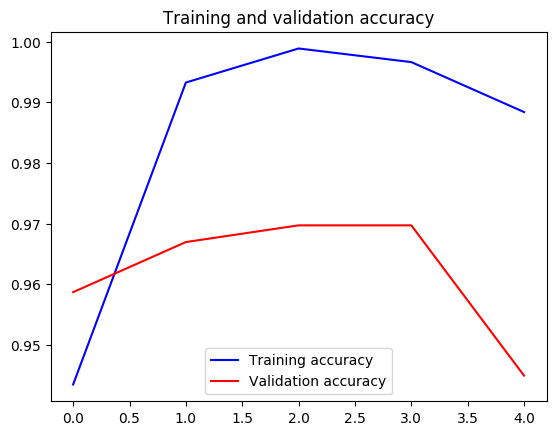

In [42]:
plot_bert_training(bert_history)

Even if the training and validation accuracy decreased, it is still fine because we add the callback in the fit section, which will help us from overfitting and restore the best weight based on lowest validation loss.

In [43]:
predictions = bert_model.predict(test_input)
logits = predictions.logits
probabilities = scipy.special.softmax(logits, axis=1)
predicted_labels = np.argmax(probabilities, axis=1)
accuracy_distilbert = accuracy_score(test_label, predicted_labels)
print("Accuracy:", accuracy_distilbert)

15/15 [==============================] - 2s 88ms/step
Accuracy: 0.9580573951434879


In [44]:
precision = precision_score(test_label, predicted_labels, average=None)
recall = recall_score(test_label, predicted_labels, average=None)
f1 = f1_score(test_label, predicted_labels, average=None)

# print("Precision for 3 classes:", precision)
# print("Recall for 3 classes:", recall)
# print("F1 score for 3 classes:", f1)
performance_matrix = pd.DataFrame([precision, recall, f1],index=['precision','recall','f1 score'])
# display(performance_matrix)
print(tabulate(performance_matrix, headers='keys', tablefmt='pretty'))

+-----------+--------------------+--------------------+--------------------+
|           |         0          |         1          |         2          |
+-----------+--------------------+--------------------+--------------------+
| precision |        0.9         | 0.958904109589041  |        1.0         |
|  recall   |        1.0         |        1.0         | 0.8272727272727273 |
| f1 score  | 0.9473684210526316 | 0.9790209790209791 | 0.9054726368159205 |
+-----------+--------------------+--------------------+--------------------+


We observe that for class 0 and 1, the precision, recall and f1 score is very high, all above 0.9.\
For class 2, the precision and f1 score is slightly lower compared to other class, but it still indicates a very good result. \
We could conclude that data imbalance issue is successfully addressed.\
*This observation maybe inaccurate because this notebook could be run multiple times, which gives slightly different result*

# End of the part I

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


# Part II - Performance Enhancement / Further Analysis

## Create (and fit the model with) a TensorFlow Dataset (TFDS)

In [45]:
raw_data = load_dataset("financial_phrasebank", "sentences_allagree")
raw_data

Found cached dataset financial_phrasebank (/home/jl8831/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

After several tried, I found it is just not possible to tokenize the dataset after convert to TFDS dataset, specifically TensorSliceDataset. \
I have my failure code in the bottom. \
The main error is that tensor object has issue when converting tensor to string object using map function, which requires tf.Py_function and tf.executing_eagerly(). But with this tf.Py_function, it is not possible to add tokenizer into the function as an input. 
Therefore, I decide to first tokenize as datasets rather than TFDS.

In [46]:
# raw_tfds = tf.data.Dataset.from_tensor_slices((
#     raw_data['train']['sentence'],
#     raw_data['train']['label']
# ))

# raw_tfds = tf.data.Dataset.from_tensor_slices((
#     {"sentence": tf.constant(raw_data['train']['sentence']),
#     "label": tf.cast(raw_data['train']['label'],tf.int64)}
# ))

# raw_tfds = tf.data.Dataset.from_tensor_slices((
#     {"sentence":raw_data['train']['sentence'], "label":raw_data['train']['label']}
# ))

tf.executing_eagerly()
# tf.data.experimental.enable_debug_mode()
# tf.config.run_functions_eagerly(True)

# next(iter(encoded_dataset))

# # def tokenize_tf_dataset(X_input, tokenizer_, max_len = 200, ):
# #     X_str = X_input.numpy().decode("UTF-8")
# #     # print(X_str)
# #     input_sequences = tokenizer_(X_str, padding="max_length",\
# #     max_length=max_len, truncation=True, return_tensors="tf")
# #     input_sequences = dict(input_sequences)
# #     input_ids = input_sequences['input_ids']
# #     attention_mask = input_sequences['attention_mask']
# #     input_dict = {
# #         'input_ids': input_ids,
# #         'attention_mask': attention_mask
# #     }
# #     return input_dict

# checkpoint = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# encoded_dataset = raw_tfds.map(lambda e: tf.Py_function(tokenize_tf_dataset, [x], [tf.string])
# encoded_dataset = raw_tfds.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length'), batched=True)
# # encoded_dataset = raw_tfds.map(lambda feature: tokenize_tf_dataset(feature, tokenizer))
# # input_sequences = tokenizer(raw_tfds, padding="max_length",max_length=200, truncation=True, return_tensors="tf")

True

### Tokenize

In [47]:
# Tokenize the raw dataset
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(checkpoint)
raw_data_tokenized = raw_data['train'].map(lambda e: tokenizer(e['sentence'], padding="max_length",max_length=200, truncation=True, return_tensors="tf"), batched=True)
raw_data_tokenized.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'label'])
features = {x: raw_data_tokenized[x] for x in ['input_ids', 'attention_mask']}

Loading cached processed dataset at /home/jl8831/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-8d4969192570968b.arrow


In [48]:
# Convert to TFDS
raw_tfds = tf.data.Dataset.from_tensor_slices((features, raw_data_tokenized["label"]))

### Train-Test Split

In [49]:
# Shuffle the data
raw_tfds = raw_tfds.shuffle(len(raw_tfds), seed=seed)

# Split into train, validation and test set
test_size = 0.2
train_size = 1 - test_size
train_temp_split = int(len(raw_tfds) * train_size)
train_temp_tfds = raw_tfds.take(train_temp_split)
test_tfds = raw_tfds.skip(train_temp_split)
train_split = int(len(train_temp_tfds) * train_size)
train_tfds = train_temp_tfds.take(train_split)
val_tfds = train_temp_tfds.skip(train_split)

In [50]:
print("Data in training set:",len(train_tfds))
print("Data in validation set:",len(val_tfds))
print("Data in test set:",len(test_tfds))

Data in training set: 1448
Data in validation set: 363
Data in test set: 453


## Address any Imbalanced Data issues

In [51]:
# Split the dataset by class

datasets_by_class = []
for class_idx in range(3):
    class_dataset = train_tfds.filter(lambda x, y: y == class_idx)
    datasets_by_class.append(class_dataset)
label0_len = len(list(datasets_by_class[0].as_numpy_iterator()))
label1_len = len(list(datasets_by_class[1].as_numpy_iterator()))
label2_len = len(list(datasets_by_class[2].as_numpy_iterator()))
print("Number of Data with label 0 in training set:", label0_len)
print("Number of Data with label 1 in training set:", label1_len)
print("Number of Data with label 2 in training set:", label2_len)

2023-05-08 04:06:21.758610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_0}}]]
2023-05-08 04:06:21.829609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_0}}]]


Number of Data with label 0 in training set: 205
Number of Data with label 1 in training set: 880
Number of Data with label 2 in training set: 370


2023-05-08 04:06:21.988684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_0}}]]


We could observe that there may exist data imbalance issue because there are more data with label 1 in the training set

In [52]:
# Oversampling
oversampled_datasets = []
samples_per_class = label1_len
for class_dataset in datasets_by_class:
    repeat_factor = int(np.ceil(samples_per_class / len(list(class_dataset.as_numpy_iterator()))))
    oversampled_dataset = class_dataset.repeat(repeat_factor)
    oversampled_datasets.append(oversampled_dataset)
train_tfds_resampled = tf.data.experimental.sample_from_datasets(oversampled_datasets)
tfds_train_len = len(list(train_tfds_resampled.as_numpy_iterator()))
train_tfds_resampled = train_tfds_resampled.shuffle(tfds_train_len, seed=seed)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


2023-05-08 04:06:22.507332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_39}}]]
2023-05-08 04:06:22.507881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_40' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_40}}]]


## Create your own Classification head

In [53]:
checkpoint = "distilbert-base-uncased"
bert_model_headless = TFDistilBertModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [54]:
# Model without classifier head
bert_model_headless.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [55]:
class BertClassificationModel(keras.Model):
    def __init__(self, encoder, train_encoder=True):
        super(BertClassificationModel, self).__init__()
        self.encoder = encoder
        self.encoder.trainable = train_encoder
        self.dropout1 = layers.Dropout(0.1)
        self.dense1 = layers.Dense(30, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.dense2 = layers.Dense(3, activation='softmax')
  
    def call(self, input):
        x = self.encoder(input)
        x = x['last_hidden_state'][:, 0, :]
        x = self.dropout1(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x

In [56]:
bert_classify_model = BertClassificationModel(bert_model_headless, train_encoder=False)

In [57]:
# We need to first pass in first batch to build the model, otherwise, we could not get model summary
first_batch_outputs = bert_classify_model(next(iter(train_tfds_resampled.batch(4))))

2023-05-08 04:06:24.170774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_7}}]]
2023-05-08 04:06:24.171403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [2264]
	 [[{{node Placeholder/_9}}]]


In [58]:
bert_classify_model.summary()

Model: "bert_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                                                   
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  23070     
                                                                 
 dropout_40 (Dropout)        multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  93        
                                                                 
Total params: 66,386,043
Trainable params: 23,163
Non-trainable params: 66,362,880
________________________

In [59]:
num_weights, num_trainable_weights = count_model_weights(bert_classify_model)
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Trainable layer 0 has 23040 weights
Trainable layer 1 has 30 weights
Trainable layer 2 has 90 weights
Trainable layer 3 has 3 weights
Total number of weights 66,386,043, number of trainable weights 23,163


### Train the head
We want to train the head first to avoid large gradients

In [60]:
bert_classify_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                )

In [61]:
def train_bert_model_extra(model, train_dataset, val_dataset, num_epochs=5, batch_size=16):
    history = model.fit(train_dataset.repeat().shuffle(buffer_size=tfds_train_len).batch(batch_size),
                        epochs=num_epochs,
                        validation_data=val_dataset.batch(batch_size),
                        steps_per_epoch=np.ceil(tfds_train_len/batch_size),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                       )
    return history

In [62]:
bert_classify_history_head = train_bert_model_extra(bert_classify_model, train_tfds_resampled, val_tfds)

Epoch 1/5


2023-05-08 04:06:25.209846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_39}}]]
2023-05-08 04:06:25.210630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_8}}]]


183/183 [==============================] - ETA: 0s - loss: 1.1106 - accuracy: 0.3798

2023-05-08 04:06:41.470393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_0}}]]


183/183 [==============================] - 19s 75ms/step - loss: 1.1106 - accuracy: 0.3798 - val_loss: 1.0194 - val_accuracy: 0.5041
Epoch 2/5
183/183 [==============================] - 12s 68ms/step - loss: 0.9750 - accuracy: 0.4911 - val_loss: 0.8868 - val_accuracy: 0.7135
Epoch 3/5
183/183 [==============================] - 12s 68ms/step - loss: 0.9104 - accuracy: 0.5700 - val_loss: 0.8162 - val_accuracy: 0.7273
Epoch 4/5
183/183 [==============================] - 12s 68ms/step - loss: 0.8640 - accuracy: 0.5789 - val_loss: 0.7322 - val_accuracy: 0.7769
Epoch 5/5
183/183 [==============================] - 12s 68ms/step - loss: 0.7993 - accuracy: 0.6359 - val_loss: 0.7063 - val_accuracy: 0.7438


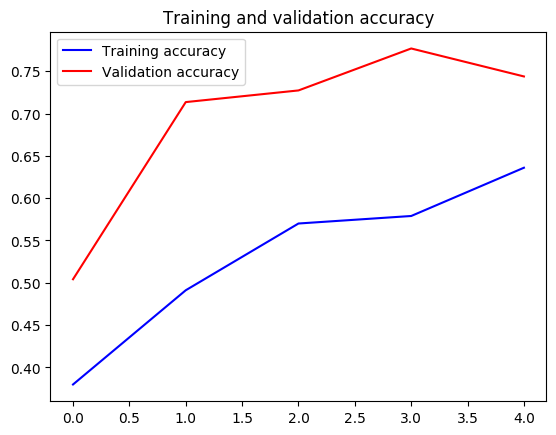

In [63]:
plot_bert_training(bert_classify_history_head)

In [64]:
accuracy_head = bert_classify_model.evaluate(test_tfds.batch(16))[1]
print("Classifier Accuracy(Head only):", accuracy_head)

 3/29 [==>...........................] - ETA: 1s - loss: 0.7155 - accuracy: 0.7083

2023-05-08 04:07:34.330805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 2s 55ms/step - loss: 0.7025 - accuracy: 0.7483
Classifier Accuracy(Head only): 0.748344361782074


### Train all layers

In [65]:
bert_classify_model.encoder.trainable = True

In [66]:
bert_classify_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = "sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                )

In [67]:
num_weights, num_trainable_weights = count_model_weights(bert_classify_model)
print(f"Total number of weights {num_weights:,}, number of trainable weights {num_trainable_weights:,}")

Total number of weights 66,386,043, number of trainable weights 66,386,043


In [68]:
bert_classify_history_all = train_bert_model_extra(bert_classify_model, train_tfds_resampled, val_tfds)

Epoch 1/5


2023-05-08 04:07:36.703289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_24}}]]
2023-05-08 04:07:36.704303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [2264]
	 [[{{node Placeholder/_9}}]]


183/183 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9249

2023-05-08 04:08:25.077290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2264]
	 [[{{node Placeholder/_2}}]]


183/183 [==============================] - 51s 187ms/step - loss: 0.2153 - accuracy: 0.9249 - val_loss: 0.0393 - val_accuracy: 0.9862
Epoch 2/5
183/183 [==============================] - 29s 157ms/step - loss: 0.0516 - accuracy: 0.9829 - val_loss: 0.0368 - val_accuracy: 0.9917
Epoch 3/5
183/183 [==============================] - 28s 154ms/step - loss: 0.0309 - accuracy: 0.9942 - val_loss: 0.0260 - val_accuracy: 0.9945
Epoch 4/5
183/183 [==============================] - 29s 156ms/step - loss: 0.0111 - accuracy: 0.9956 - val_loss: 1.0154e-04 - val_accuracy: 1.0000
Epoch 5/5
183/183 [==============================] - 28s 150ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0117 - val_accuracy: 0.9945


## In-depth Error Analysis

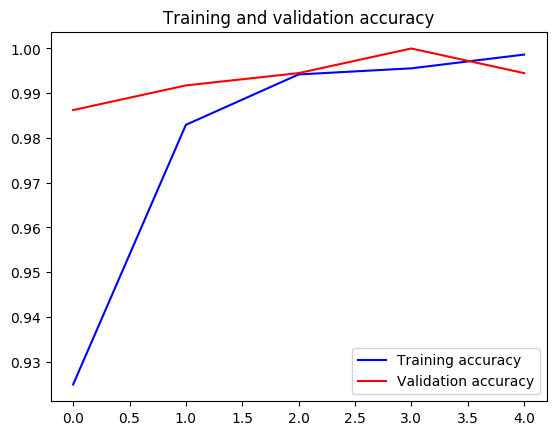

In [69]:
plot_bert_training(bert_classify_history_all)

In [70]:
accuracy_all_layer = bert_classify_model.evaluate(test_tfds.batch(16))[1]
print(f"Classifier Accuracy(All layers):{accuracy_all_layer:.4f}")

 3/29 [==>...........................] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

2023-05-08 04:10:21.101563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2264,200]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 2s 55ms/step - loss: 0.0031 - accuracy: 0.9978
Classifier Accuracy(All layers):0.9978


We evaluate our customized-classifier model on the out-of-sample test set, we actually found out that accuracy for this model is very high of 0.99, which indicates that our model is not overfitting and is very robust. 

In [71]:
true_labels_tfds = []
predicted_labels_tfds = []

for batch_inputs, batch_labels in test_tfds:
    predictions = bert_classify_model.predict(batch_inputs, verbose=False)[0]
    if len(predictions.shape) == 1:
        batch_predicted_labels = [np.argmax(predictions)]
    else:
        batch_predicted_labels = np.argmax(predictions, axis=1)
    true_labels_tfds.extend([batch_labels.numpy()])
    predicted_labels_tfds.extend(batch_predicted_labels)

accuracy = np.mean(np.array(predicted_labels_tfds) == np.array(true_labels_tfds))
print(f"Accuracy: {accuracy:.4f}")

2023-05-08 04:10:22.834576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2264]
	 [[{{node Placeholder/_2}}]]


Accuracy: 0.9647


To better evaluate the error for this model, we would try to get the predication labels predicted by the model. \
There are some small difference in accuracy between we predicted the label individually or through a batch, but the difference is small and negligible.

In [72]:
cm = confusion_matrix(true_labels_tfds, predicted_labels_tfds)
cm_df = pd.DataFrame(cm)
print(tabulate(cm_df,headers='keys', tablefmt='pretty'))

+---+----+-----+----+
|   | 0  |  1  | 2  |
+---+----+-----+----+
| 0 | 52 |  7  | 0  |
| 1 | 0  | 287 | 1  |
| 2 | 0  |  8  | 98 |
+---+----+-----+----+


We saw that mis-classification for this model is very low, the main error falls in data with label 1, which is neutral. \
It is highly possible that because class 1 data is more than other class, so model will more likely to mis classify on label 1.\
*This observation maybe inaccurate because this notebook could be run multiple times, which gives slightly different result*

In [73]:
precision = precision_score(true_labels_tfds, predicted_labels_tfds, average=None)
recall = recall_score(true_labels_tfds, predicted_labels_tfds, average=None)
f1 = f1_score(true_labels_tfds, predicted_labels_tfds, average=None)

performance_matrix = pd.DataFrame([precision, recall, f1],index=['precision','recall','f1 score'])
# display(performance_matrix)
print(tabulate(performance_matrix, headers='keys', tablefmt='pretty'))

+-----------+--------------------+--------------------+--------------------+
|           |         0          |         1          |         2          |
+-----------+--------------------+--------------------+--------------------+
| precision |        1.0         | 0.9503311258278145 |  0.98989898989899  |
|  recall   | 0.8813559322033898 | 0.9965277777777778 | 0.9245283018867925 |
| f1 score  | 0.936936936936937  | 0.9728813559322034 | 0.9560975609756097 |
+-----------+--------------------+--------------------+--------------------+


From the performance matrix, we further assess the accuracy for each class. \
We could see that the precision, recall and f1 score for all 3 class is above 0.9, which indicates that this model is very robust and does not have data imbalance issue.\
*This observation maybe inaccurate because this notebook could be run multiple times, which gives slightly different result*

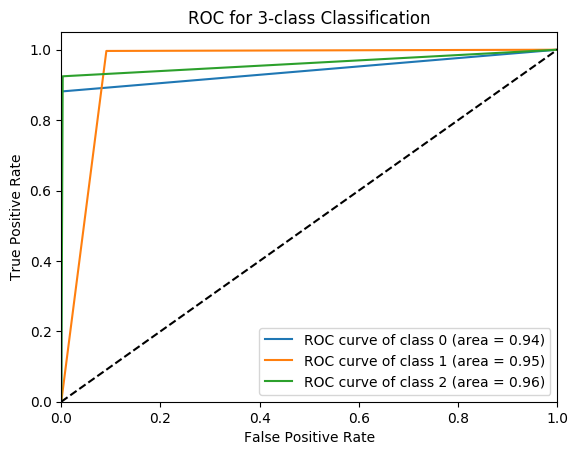

In [74]:
label_binarizer = LabelBinarizer()
true_labels_tfds_one_hot = label_binarizer.fit_transform(true_labels_tfds)
predicted_labels_tfds_one_hot = label_binarizer.transform(predicted_labels_tfds)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels_tfds_one_hot[:, i], predicted_labels_tfds_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for 3-class Classification')
plt.legend(loc="lower right")
plt.show()

From the ROC/AUC curve, we could found that the overall accuracy of model is relative high, with all AUC score higher than 0.95, which indicates that this model is robust.\
*This observation maybe inaccurate because this notebook could be run multiple times, which gives slightly different result*

In [75]:
print(tabulate(cm_df,headers='keys', tablefmt='pretty'))

+---+----+-----+----+
|   | 0  |  1  | 2  |
+---+----+-----+----+
| 0 | 52 |  7  | 0  |
| 1 | 0  | 287 | 1  |
| 2 | 0  |  8  | 98 |
+---+----+-----+----+


Recall the confusion matrix, indeed, as we observed in the confusion matrix, we found a pattern that the misclassification rate for label 1 as label 2 in relative high. \
It is understandable for some neutral text is more likely to classified as positive text because people might have different interpretation for a neutral text, same applies for the model.

## Use different "flavors" of the dataset

We would like to see if our model still performs well when applying to 66% agreed dataset. \
We choose 66% because it means sentence classification is still majority agreed. \
I will follow the process and model of the basic part.

In [76]:
raw_data_66 = load_dataset("financial_phrasebank", "sentences_66agree")

Found cached dataset financial_phrasebank (/home/jl8831/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

### Preprocessing, tokenize and oversampling

In [77]:
test_size = 0.2
raw_data_split_66 = raw_data_66['train'].train_test_split(test_size=test_size)
train_temp_set_66 = raw_data_split_66['train']
test_set_66 = raw_data_split_66['test']
train_temp_set_split_66 = train_temp_set_66.train_test_split(test_size=test_size)
train_set_66 = train_temp_set_split_66['train']
val_set_66 = train_temp_set_split_66['test']
print("Data in training set:",len(train_set_66))
print("Data in validation set:",len(val_set_66))
print("Data in test set:",len(test_set_66))

Data in training set: 2698
Data in validation set: 675
Data in test set: 844


In [78]:
train_df_66 = train_set_66.to_pandas()

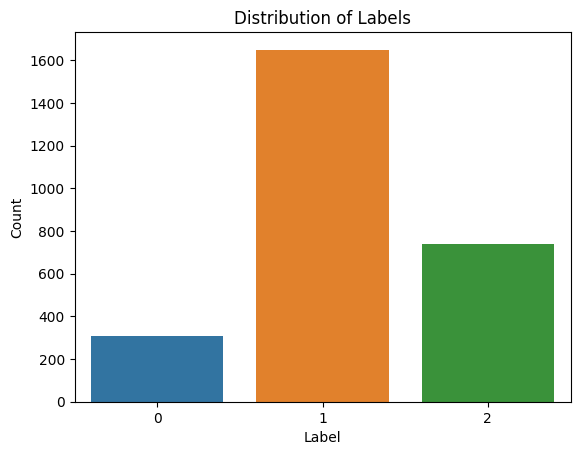

In [79]:
sns.countplot(data=train_df_66, x='label')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [80]:
train_list_66 = train_set_66['sentence']
train_label_66 = train_set_66['label']
val_list_66 = val_set_66['sentence']
val_label_66 = val_set_66['label']
test_list_66 = test_set_66['sentence']
test_label_66 = test_set_66['label']

In [81]:
checkpoint = "distilbert-base-uncased"
tokenizer_66 = AutoTokenizer.from_pretrained(checkpoint)
train_input_66, train_label_66 = tokenize_dataset(train_list_66, train_label_66, tokenizer_66)
val_input_66, val_label_66 = tokenize_dataset(val_list_66, val_label_66, tokenizer_66)
test_input_66, test_label_66 = tokenize_dataset(test_list_66, test_label_66, tokenizer_66)

In [82]:
train_input_resampled_66, train_label_resampled_66 = oversampling_bert(train_input_66, train_label_66)

### Train the model

In [83]:
checkpoint = "distilbert-base-uncased"
bert_model_66 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_60', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Train the head first

In [84]:
bert_model_66.layers[0].trainable = False
bert_model_66.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [85]:
bert_history_head_66 = train_bert_model(bert_model_66, train_input_resampled_66, train_label_resampled_66,val_input_66,val_label_66)

Epoch 1/5
310/310 [==============================] - 27s 72ms/step - loss: 0.8618 - accuracy: 0.6173 - val_loss: 0.6941 - val_accuracy: 0.7333
Epoch 2/5
310/310 [==============================] - 21s 68ms/step - loss: 0.6472 - accuracy: 0.7202 - val_loss: 0.7307 - val_accuracy: 0.6844
Epoch 3/5
310/310 [==============================] - 21s 68ms/step - loss: 0.5650 - accuracy: 0.7633 - val_loss: 0.5538 - val_accuracy: 0.7644
Epoch 4/5
310/310 [==============================] - 21s 68ms/step - loss: 0.5244 - accuracy: 0.7801 - val_loss: 0.5256 - val_accuracy: 0.7852
Epoch 5/5
310/310 [==============================] - 21s 68ms/step - loss: 0.5006 - accuracy: 0.7902 - val_loss: 0.5569 - val_accuracy: 0.7630


Train all layers

In [86]:
bert_model_66.layers[0].trainable = True
bert_model_66.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [87]:
bert_history_66 = train_bert_model(bert_model_66, train_input_resampled_66, train_label_resampled_66,val_input_66,val_label_66)

Epoch 1/5
310/310 [==============================] - 70s 177ms/step - loss: 0.2698 - accuracy: 0.8973 - val_loss: 0.3305 - val_accuracy: 0.8711
Epoch 2/5
310/310 [==============================] - 48s 154ms/step - loss: 0.0688 - accuracy: 0.9772 - val_loss: 0.4369 - val_accuracy: 0.8770
Epoch 3/5
310/310 [==============================] - 47s 153ms/step - loss: 0.0353 - accuracy: 0.9911 - val_loss: 0.6335 - val_accuracy: 0.8874
Epoch 4/5
310/310 [==============================] - 47s 152ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.5437 - val_accuracy: 0.8652


### Evaluate the result and Error Analysis

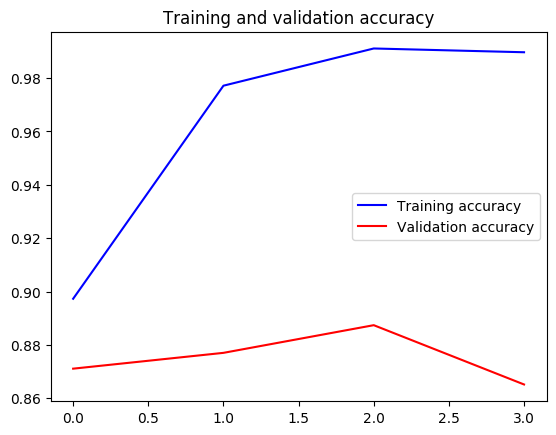

In [88]:
plot_bert_training(bert_history_66)

In [89]:
predictions_66 = bert_model_66.predict(test_input_66)
logits = predictions_66.logits
probabilities = scipy.special.softmax(logits, axis=1)
predicted_labels_66 = np.argmax(probabilities, axis=1)
accuracy_66 = accuracy_score(test_label_66, predicted_labels_66)
print("Accuracy:", accuracy_66)

27/27 [==============================] - 4s 91ms/step
Accuracy: 0.8921800947867299


In [90]:
precision_66 = precision_score(test_label_66, predicted_labels_66, average=None)
recall_66 = recall_score(test_label_66, predicted_labels_66, average=None)
f1_66 = f1_score(test_label_66, predicted_labels_66, average=None)
performance_matrix_66 = pd.DataFrame([precision_66, recall_66, f1_66],index=['precision','recall','f1 score'])
print(tabulate(performance_matrix_66, headers='keys', tablefmt='pretty'))

+-----------+--------------------+--------------------+--------------------+
|           |         0          |         1          |         2          |
+-----------+--------------------+--------------------+--------------------+
| precision | 0.897196261682243  |  0.89272030651341  | 0.8883720930232558 |
|  recall   | 0.7868852459016393 | 0.9510204081632653 | 0.8232758620689655 |
| f1 score  | 0.8384279475982532 | 0.9209486166007905 | 0.8545861297539149 |
+-----------+--------------------+--------------------+--------------------+


### Discussion of using different "flavors" dataset

As we tried a different flavor of dataset of 66% agreed, we actually observe that the accuracy for the distilbert model decreased slightly, dropping from around 95%+ to around 85%-90%. \
The result is not a surprise given that only 66% of human agreed on the label and the model is still able to get decent result above 85%. \
Also, the mis-classification rate for label 0 and 2 is higher than label 1(neutral), compared with the all-agreed flavors where mis-classification rate is around the same for all 3 classes, it may signal that these mis-classified sentences are not even all-agreed by humans.

## Experiment with different Pre-Trained models

In this part, I will try to use the bert-model rather than distilbert model and compare the accuracy. I will use the same data input as in the basic part.

In [91]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
train_input_bert, train_label_bert = tokenize_dataset(train_list, train_label, tokenizer)
val_input_bert, val_label_bert = tokenize_dataset(val_list, val_label, tokenizer)
test_input_bert, test_label_bert = tokenize_dataset(test_list, test_label, tokenizer)
train_input_resampled_bert, train_label_resampled_bert = oversampling_bert(train_input_bert, train_label_bert)

In [92]:
checkpoint = "bert-base-uncased"
bert_model_bert = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
bert_model_bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_98 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


Train the head first

In [94]:
bert_model_bert.layers[0].trainable = False
bert_model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [95]:
bert_history_head_bert = train_bert_model(bert_model_bert, train_input_resampled_bert, train_label_resampled_bert,val_input_bert,val_label_bert)

Epoch 1/5
167/167 [==============================] - 35s 151ms/step - loss: 1.0733 - accuracy: 0.4071 - val_loss: 1.0525 - val_accuracy: 0.4628
Epoch 2/5
167/167 [==============================] - 23s 137ms/step - loss: 1.0405 - accuracy: 0.4596 - val_loss: 1.0089 - val_accuracy: 0.5344
Epoch 3/5
167/167 [==============================] - 23s 135ms/step - loss: 1.0117 - accuracy: 0.4944 - val_loss: 1.0301 - val_accuracy: 0.4683
Epoch 4/5
167/167 [==============================] - 23s 137ms/step - loss: 0.9935 - accuracy: 0.4996 - val_loss: 1.0037 - val_accuracy: 0.5014
Epoch 5/5
167/167 [==============================] - 23s 137ms/step - loss: 0.9699 - accuracy: 0.5588 - val_loss: 0.9219 - val_accuracy: 0.6226


Train all layers

In [96]:
bert_model_bert.layers[0].trainable = True
bert_model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [97]:
bert_history_bert = train_bert_model(bert_model_bert, train_input_resampled_bert, train_label_resampled_bert,val_input_bert,val_label_bert)

Epoch 1/5
167/167 [==============================] - 86s 327ms/step - loss: 0.2251 - accuracy: 0.9169 - val_loss: 0.0874 - val_accuracy: 0.9752
Epoch 2/5
167/167 [==============================] - 51s 303ms/step - loss: 0.0390 - accuracy: 0.9906 - val_loss: 0.1505 - val_accuracy: 0.9587
Epoch 3/5
167/167 [==============================] - 50s 301ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 0.2189 - val_accuracy: 0.9449
Epoch 4/5
167/167 [==============================] - 50s 302ms/step - loss: 0.0378 - accuracy: 0.9914 - val_loss: 0.2361 - val_accuracy: 0.9449


### Evaluate the result and Error Analysis

In [98]:
predictions_bert = bert_model_bert.predict(test_input_bert)
logits = predictions_bert.logits
probabilities = scipy.special.softmax(logits, axis=1)
predicted_labels_bert = np.argmax(probabilities, axis=1)
accuracy_bert = accuracy_score(test_label_bert, predicted_labels_bert)
print("Accuracy:", accuracy_bert)

15/15 [==============================] - 5s 179ms/step
Accuracy: 0.9690949227373068


### Also try with RoBERTa model

In [99]:
checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
train_input_roberta, train_label_roberta = tokenize_dataset(train_list, train_label, tokenizer)
val_input_roberta, val_label_roberta = tokenize_dataset(val_list, val_label, tokenizer)
test_input_roberta, test_label_roberta = tokenize_dataset(test_list, test_label, tokenizer)

In [100]:
train_input_resampled_roberta, train_label_resampled_roberta = oversampling_bert(train_input_roberta, train_label_roberta)

In [101]:
checkpoint = "xlm-roberta-base"
bert_model_roberta = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

Some layers of TFXLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
bert_model_roberta.summary()

Model: "tfxlm_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainLa  multiple                 277453056 
 yer)                                                            
                                                                 
 classifier (TFXLMRobertaCla  multiple                 592899    
 ssificationHead)                                                
                                                                 
Total params: 278,045,955
Trainable params: 278,045,955
Non-trainable params: 0
_________________________________________________________________


Train the head first

In [103]:
bert_model_roberta.layers[0].trainable = False
bert_model_roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [104]:
bert_history_head_roberta = train_bert_model(bert_model_roberta, train_input_resampled_roberta, train_label_resampled_roberta,val_input_roberta,val_label_roberta)

Epoch 1/5
167/167 [==============================] - 37s 156ms/step - loss: 1.0372 - accuracy: 0.4708 - val_loss: 0.9499 - val_accuracy: 0.7383
Epoch 2/5
167/167 [==============================] - 23s 139ms/step - loss: 0.9399 - accuracy: 0.5704 - val_loss: 0.8833 - val_accuracy: 0.7493
Epoch 3/5
167/167 [==============================] - 23s 139ms/step - loss: 0.8710 - accuracy: 0.6172 - val_loss: 0.7654 - val_accuracy: 0.6722
Epoch 4/5
167/167 [==============================] - 23s 140ms/step - loss: 0.8368 - accuracy: 0.6202 - val_loss: 0.7050 - val_accuracy: 0.7438
Epoch 5/5
167/167 [==============================] - 23s 139ms/step - loss: 0.8174 - accuracy: 0.6431 - val_loss: 0.6886 - val_accuracy: 0.7603


Train all layers

In [105]:
bert_model_roberta.layers[0].trainable = True
bert_model_roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )

In [106]:
bert_history_roberta = train_bert_model(bert_model_roberta, train_input_resampled_roberta, train_label_resampled_roberta,val_input_roberta,val_label_roberta)

Epoch 1/5
167/167 [==============================] - 100s 409ms/step - loss: 0.2994 - accuracy: 0.9082 - val_loss: 0.2615 - val_accuracy: 0.9504
Epoch 2/5
167/167 [==============================] - 56s 335ms/step - loss: 0.1388 - accuracy: 0.9637 - val_loss: 0.1509 - val_accuracy: 0.9504
Epoch 3/5
167/167 [==============================] - 54s 322ms/step - loss: 0.0835 - accuracy: 0.9790 - val_loss: 0.2257 - val_accuracy: 0.9366
Epoch 4/5
167/167 [==============================] - 53s 319ms/step - loss: 0.1374 - accuracy: 0.9577 - val_loss: 0.2258 - val_accuracy: 0.9587
Epoch 5/5
167/167 [==============================] - 54s 322ms/step - loss: 0.0656 - accuracy: 0.9828 - val_loss: 0.2378 - val_accuracy: 0.9421


### Evaluate the result and Error Analysis

In [107]:
predictions_roberta = bert_model_roberta.predict(test_input_roberta)
logits = predictions_roberta.logits
probabilities = scipy.special.softmax(logits, axis=1)
predicted_labels_roberta = np.argmax(probabilities, axis=1)
accuracy_roberta = accuracy_score(test_label_roberta, predicted_labels_roberta)
print("Accuracy:", accuracy_roberta)

15/15 [==============================] - 5s 179ms/step
Accuracy: 0.9470198675496688


### Compare the performance of distilBert, Bert and RoBERTa and discuss

In [108]:
performance_comp = pd.DataFrame([accuracy_distilbert, accuracy_bert, accuracy_roberta],index=['distilbert','bert', 'RoBERTa'],columns=['model accuracy'])
print(tabulate(performance_comp, headers='keys', tablefmt='pretty'))

+------------+--------------------+
|            |   model accuracy   |
+------------+--------------------+
| distilbert | 0.9580573951434879 |
|    bert    | 0.9690949227373068 |
|  RoBERTa   | 0.9470198675496688 |
+------------+--------------------+


We could see that all three models have very close accuracy around 95% on out-of-sample dataset. \
This result shows that even with more parameters and more complex, the bert-base model and RoBERTa model does not outperform the distilbert model. \
This may also infer that current accuracy is hardly to be improved. 

## Experiment with Fine-Tuning

### Main question:
**Does out of sample performance vary with changing**
- the number of examples in Fine-Tuning
    - what is the smallest number that you think is sufficient
- there are many choices of proper subsets of a given size
    - does it matter which one you choose ?


We import the model and follow the process for basic part first

In [109]:
checkpoint = "distilbert-base-uncased"
bert_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_156', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

We try to reduce the training set size, to see what size is sufficient to train the model and retain moderate accuracy

In [110]:
size_ft = [200, 100, 50, 25, 10]
acc_ft = {}
for i in size_ft:
    shuffled_dataset = train_set.shuffle(seed=seed)
    train_set_subset = shuffled_dataset.select(range(i))
    train_list_subset = train_set_subset['sentence']
    train_label_subset = train_set_subset['label']
    val_list = val_set['sentence']
    val_label = val_set['label']
    test_list = test_set['sentence']
    test_label = test_set['label']
    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    train_input_subset, train_label_subset = tokenize_dataset(train_list_subset, train_label_subset, tokenizer)
    val_input, val_label = tokenize_dataset(val_list, val_label, tokenizer)
    test_input, test_label = tokenize_dataset(test_list, test_label, tokenizer)
    train_input_resampled_subset, train_label_resampled_subset = oversampling_bert(train_input_subset, train_label_subset)
    checkpoint = "distilbert-base-uncased"
    bert_model_ft = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    bert_model_ft.layers[0].trainable = False
    bert_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    loss = SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=["accuracy"]
                )
    bert_history_head_ft = train_bert_model(bert_model_ft, train_input_resampled_subset, train_label_resampled_subset,val_input,val_label, num_epochs=3, verbose_=False)
    bert_model_ft.layers[0].trainable = True
    bert_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                  loss = SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"]
            )
    bert_history_ft = train_bert_model(bert_model_ft, train_input_resampled_subset, train_label_resampled_subset,val_input,val_label, num_epochs=3,verbose_=False)
    predictions_ft = bert_model_ft.predict(test_input,verbose=False)
    logits = predictions_ft.logits
    probabilities = scipy.special.softmax(logits, axis=1)
    predicted_labels_ft = np.argmax(probabilities, axis=1)
    accuracy_ft = accuracy_score(test_label, predicted_labels_ft)
    acc_ft[i] = accuracy_ft
    

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_176']
You should probably TRAIN this model on a down-stream task to be able to use 

In [111]:
acc_ft_df = pd.DataFrame(acc_ft,index=['accuracy']).T
acc_ft_df

,accuracy
200,0.942605
100,0.916115
50,0.768212
25,0.750552
10,0.388521


As we observed in the dataframe, as we decrease the data size in the training, the accuracy drops. \
The turning point for accuracy to fall below a threshold of 80% is when training size is less than 100. \
Therefore, we might speculate that when fitting more than 100 training data to the distilbert model, it will gives us a satisfactory result.